
# Extrapolation nowcast

This tutorial shows how to compute and plot an extrapolation nowcast using
Finnish radar data.


In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from pysteps import io, motion, nowcasts, rcparams, verification
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver

Pysteps configuration file found at: /home/zhangting/src/rainnet/verification/test/pystepsrc



## Read the radar input images

First, we will import the sequence of radar composites.
You need the pysteps-data archive downloaded and the pystepsrc file
configured with the data_source paths pointing to data folders.



In [2]:
# Selected case
date = datetime.strptime("201609281600", "%Y%m%d%H%M")
data_source = rcparams.data_sources["fmi"]
n_leadtimes = 12

### Load the data from the archive



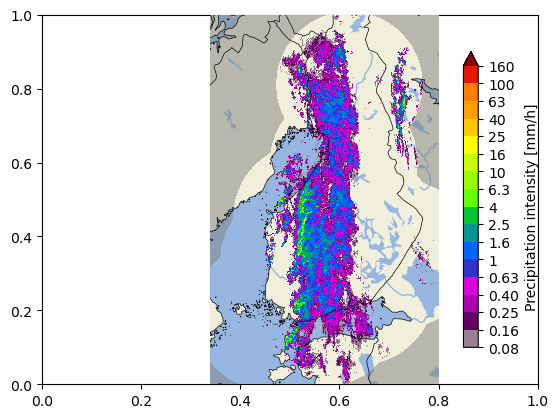

{'accutime': 5.0,
 'cartesian_unit': 'm',
 'institution': 'Finnish Meteorological Institute',
 'projection': '+proj=stere  +lon_0=25E +lat_0=90N +lat_ts=60 +a=6371288 '
               '+x_0=380886.310 +y_0=3395677.920 +no_defs',
 'threshold': np.float64(-10.0),
 'timestamps': array([datetime.datetime(2016, 9, 28, 15, 50),
       datetime.datetime(2016, 9, 28, 15, 55),
       datetime.datetime(2016, 9, 28, 16, 0)], dtype=object),
 'transform': 'dB',
 'unit': 'mm/h',
 'x1': 0.0049823258887045085,
 'x2': 759752.2852757066,
 'xpixelsize': 999.674053,
 'y1': 0.009731985162943602,
 'y2': 1225544.6588913496,
 'yorigin': 'upper',
 'ypixelsize': 999.62859,
 'zerovalue': -15.0,
 'zr_a': 223.0,
 'zr_b': 1.53}


In [6]:
root_path = data_source["root_path"]
path_fmt = data_source["path_fmt"]
fn_pattern = data_source["fn_pattern"]
fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]
timestep = data_source["timestep"]

# Find the input files from the archive
fns = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep, num_prev_files=2
)

# Read the radar composites
importer = io.get_method(importer_name, "importer")
Z, _, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

# Convert to rain rate
R, metadata = conversion.to_rainrate(Z, metadata)

# Plot the rainfall field
plot_precip_field(R[-1, :, :], geodata=metadata)
plt.show()

# Store the last frame for plotting it later later
R_ = R[-1, :, :].copy()

# Log-transform the data to unit of dBR, set the threshold to 0.1 mm/h,
# set the fill value to -15 dBR
R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

# Nicely print the metadata
pprint(metadata)

## Compute the nowcast

The extrapolation nowcast is based on the estimation of the motion field,
which is here performed using a local tracking approach (Lucas-Kanade).
The most recent radar rainfall field is then simply advected along this motion
field in oder to produce an extrapolation forecast.



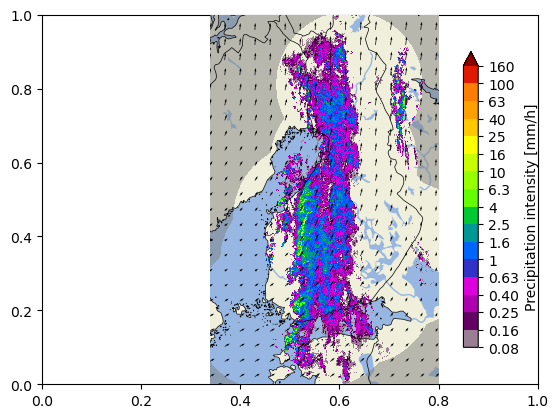

In [4]:
# Estimate the motion field with Lucas-Kanade
oflow_method = motion.get_method("LK")
V = oflow_method(R[-3:, :, :])

# Extrapolate the last radar observation
extrapolate = nowcasts.get_method("extrapolation")
R[~np.isfinite(R)] = metadata["zerovalue"]
R_f = extrapolate(R[-1, :, :], V, n_leadtimes)

# Back-transform to rain rate
R_f = transformation.dB_transform(R_f, threshold=-10.0, inverse=True)[0]

# Plot the motion field
plot_precip_field(R_, geodata=metadata)
quiver(V, geodata=metadata, step=50)
plt.show()

## Verify with FSS

The fractions skill score (FSS) provides an intuitive assessment of the
dependency of skill on spatial scale and intensity, which makes it an ideal
skill score for high-resolution precipitation forecasts.



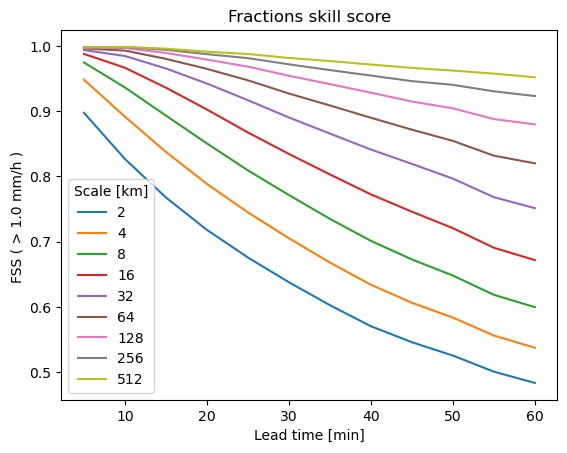

In [5]:
# Find observations in the data archive
fns = io.archive.find_by_date(
    date,
    root_path,
    path_fmt,
    fn_pattern,
    fn_ext,
    timestep,
    num_prev_files=0,
    num_next_files=n_leadtimes,
)
# Read the radar composites
R_o, _, metadata_o = io.read_timeseries(fns, importer, **importer_kwargs)
R_o, metadata_o = conversion.to_rainrate(R_o, metadata_o, 223.0, 1.53)

# Compute fractions skill score (FSS) for all lead times, a set of scales and 1 mm/h
fss = verification.get_method("FSS")
scales = [2, 4, 8, 16, 32, 64, 128, 256, 512]
thr = 1.0
score = []
for i in range(n_leadtimes):
    score_ = []
    for scale in scales:
        score_.append(fss(R_f[i, :, :], R_o[i + 1, :, :], thr, scale))
    score.append(score_)

plt.figure()
x = np.arange(1, n_leadtimes + 1) * timestep
plt.plot(x, score)
plt.legend(scales, title="Scale [km]")
plt.xlabel("Lead time [min]")
plt.ylabel("FSS ( > 1.0 mm/h ) ")
plt.title("Fractions skill score")
plt.show()

# sphinx_gallery_thumbnail_number = 3